# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate
import sklearn.discriminant_analysis as DA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
filename="SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

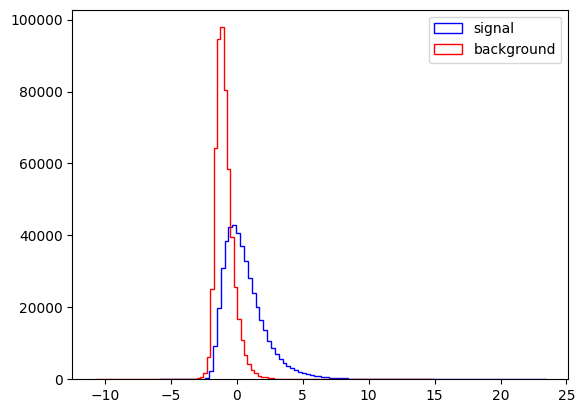

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

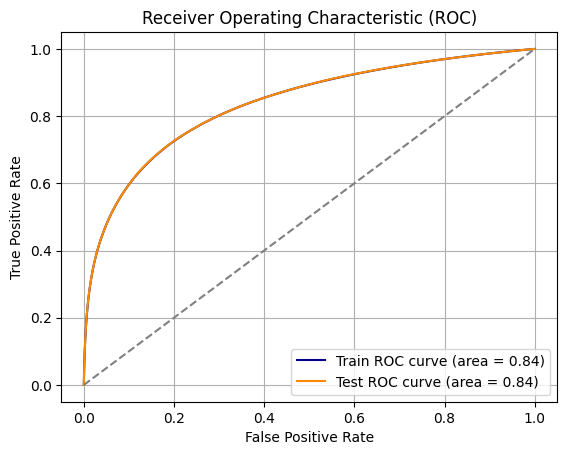

Training AUC: 0.8361729591588448
Testing AUC: 0.8364009731285001
No significant bias observed.


In [7]:
#Get ROC curve data for training sample
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
roc_auc_train = auc(fpr_train, tpr_train)

# Get ROC curve data for testing sample
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkblue', label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='darkorange', label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Check for bias
print("Training AUC:", roc_auc_train)
print("Testing AUC:", roc_auc_test)
if roc_auc_train - roc_auc_test > 0.05:
    print("Potential bias: Training AUC is significantly higher than testing AUC.")
else:
    print("No significant bias observed.")

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

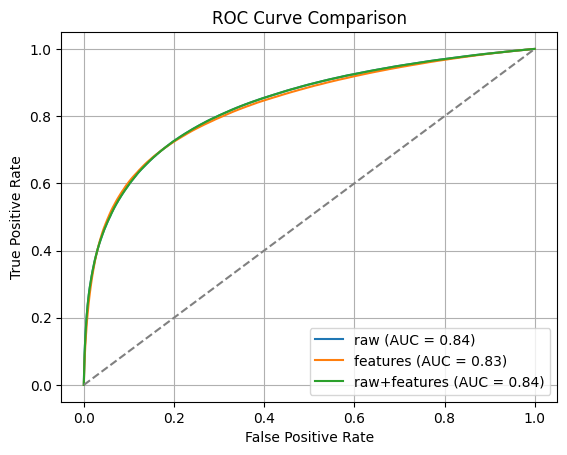

In [8]:
# Define feature sets
raw_features = VarNames[1:]
derived_features = ["l_1_pT", "l_2_pT", "MET"]
combined_features = list(set(raw_features + derived_features)) 

feature_sets = {
    "raw": raw_features,
    "features": derived_features,
    "raw+features": combined_features
}

# Train and evaluate for each feature set
plt.figure()
for feature_set_name, features in feature_sets.items():
    Fisher = DA.LinearDiscriminantAnalysis()
    Fisher.fit(Train_Sample[features], y_Train)
    
    fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(Test_Sample[features]))
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{feature_set_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

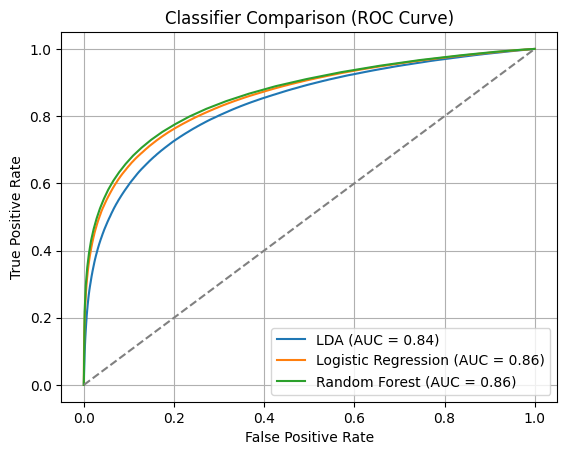

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define classifiers
classifiers = {
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Random Forest": RandomForestClassifier(n_estimators=30)
}

# Train and evaluate
plt.figure()
for name, model in classifiers.items():
    model.fit(X_Train, y_Train)
    y_scores = model.decision_function(X_Test) if hasattr(model, "decision_function") else model.predict_proba(X_Test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_Test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Classifier Comparison (ROC Curve)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
best_classifier = RandomForestClassifier(random_state=42) 
best_classifier.fit(X_train, y_train)

# Predict probabilities 
y_prob = best_classifier.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Calculate signal and background
N_S = np.sum((y_pred == 1) & (y_test == 1))  # True positives
N_B = np.sum((y_pred == 1) & (y_test == 0))  # False positives

# maximal significance
sigma_S = N_S / np.sqrt(N_S + N_B) if (N_S + N_B) > 0 else 0
print(f"Maximal Significance (σ_S): {sigma_S:.2f}")

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 
